# OpAmp filter circuits
Last update: 16 Apr 2022  

For small circuits with a handful of components, symbolic solutions of the node equations can be of interest and compared to examples given in college textbooks. By starting with a circuit drawn with a schematic capture program like LTspice, the netlist can be generated automatically eliminating setup errors. Then with the python code discussed [here](https://github.com/Tiburonboy/Symbolic-modified-nodal-analysis), the node equations can be generated automatically, which can then be solved with either SymPy or SciPy. The kinds of circuit analysis problems that electrical engineering students are asked to do as homework become very easy with a little bit of the python code. 

This notebook/blog post examines operational amplifiers ([opamp](https://en.wikipedia.org/wiki/Operational_amplifier)) used in filter circuits. Symbolic and numerical solutions are obtained from the circuit netlist. Nodal equations for the networks were generated from the net list exported from LTspice. SciPy libraries are used to plot filter [impulse response](https://en.wikipedia.org/wiki/Impulse_response), [step response](https://en.wikipedia.org/wiki/Step_response), [Bode plot](https://en.wikipedia.org/wiki/Bode_plot) and [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay) of the filters. The jupyter notebook can be found [here](https://github.com/Tiburonboy/EE_jupyter_notebooks). The filter circuits examined employ an opamp model that requires a DC path from the output terminal to the negative input terminal of the opamp. No error checking is provided and if the condition is violated, the results will be likely erroneous. 

In [38]:
import numpy as np
from sympy import *
from scipy import signal
import matplotlib.pyplot as plt
init_printing()

## OpAmp circuit 1
This circuit shown below is a 3rd order low pass filter using three resistors, three capacitors and one opamp. The filter is a [Sallen–Key](https://en.wikipedia.org/wiki/Sallen%E2%80%93Key_topology) type filter with capacitance values of 0.1uF and a cut off of 1000Hz. 

The schematic of the filter was entered into LTspice and the netlist obtained:
```
V1 1 0 AC 1
R1 1 2 22.65k
R2 2 3 22.65k
R3 3 4 22.65k
R4 5 0 1k
C1 2 0 6940p
C2 3 5 0.01µ
C3 0 4 1783p
O 4 5 5 * LTspice opamp lines replaced
*XU1 4 5 N002 N001 5 LT1037
*Vneg1 0 N001 15
*Vpos1 N002 0 15
```
The netlist was edited to remove the opamp power connections and the values of the components were converted to exponential notation with units of Ohms, Farads and Henerys.  

The MNA [code](https://github.com/Tiburonboy/Symbolic-modified-nodal-analysis) generated the following network equations:
```
[[Eq(I_V1 + v1/R1 - v2/R1, 0)],
[Eq(v2*(C1*s + 1/R2 + 1/R1) - v3/R2 - v1/R1, 0)],
[Eq(-C2*s*v5 + v3*(C2*s + 1/R3 + 1/R2) - v4/R3 - v2/R2, 0)],
[Eq(v4*(C3*s + 1/R3) - v3/R3, 0)],
[Eq(-C2*s*v3 + I_O + v5*(C2*s + 1/R4), 0)],
[Eq(v1, V1)],
[Eq(v4 - v5, 0)]]
```

Reference  
1. 3rd order LPF, 10.2, Handbook of Operational Amplifier Circuit Design, David F. Stout, McGraw-Hill 1976
2. https://en.wikipedia.org/wiki/Sallen%E2%80%93Key_topology
3. https://www.ti.com/lit/an/sloa024b/sloa024b.pdf

The following symbols and equations are initialized for the SymPy environment.

In [39]:
# declare the following symbols
v3, V1, C3, v1, v5, C1, I_O, R1, R4, R3, s, v2, v4, I_V1, R2, C2 = symbols('v3 V1 C3 v1 v5 C1 I_O R1 R4 R3 s v2 v4 I_V1 R2 C2')

# use the equations generated by nodal analysis
equ = Matrix(
    [[Eq(I_V1 + v1/R1 - v2/R1, 0)],
    [Eq(v2*(C1*s + 1/R2 + 1/R1) - v3/R2 - v1/R1, 0)],
    [Eq(-C2*s*v5 + v3*(C2*s + 1/R3 + 1/R2) - v4/R3 - v2/R2, 0)],
    [Eq(v4*(C3*s + 1/R3) - v3/R3, 0)],
    [Eq(-C2*s*v3 + I_O + v5*(C2*s + 1/R4), 0)],
    [Eq(v1, V1)],
    [Eq(v4 - v5, 0)]])
equ

⎡                    v₁   v₂                 ⎤
⎢             I_V1 + ── - ── = 0             ⎥
⎢                    R₁   R₁                 ⎥
⎢                                            ⎥
⎢        ⎛       1    1 ⎞   v₃   v₁          ⎥
⎢     v₂⋅⎜C₁⋅s + ── + ──⎟ - ── - ── = 0      ⎥
⎢        ⎝       R₂   R₁⎠   R₂   R₁          ⎥
⎢                                            ⎥
⎢              ⎛       1    1 ⎞   v₄   v₂    ⎥
⎢-C₂⋅s⋅v₅ + v₃⋅⎜C₂⋅s + ── + ──⎟ - ── - ── = 0⎥
⎢              ⎝       R₃   R₂⎠   R₃   R₂    ⎥
⎢                                            ⎥
⎢             ⎛       1 ⎞   v₃               ⎥
⎢          v₄⋅⎜C₃⋅s + ──⎟ - ── = 0           ⎥
⎢             ⎝       R₃⎠   R₃               ⎥
⎢                                            ⎥
⎢                        ⎛       1 ⎞         ⎥
⎢    -C₂⋅s⋅v₃ + I_O + v₅⋅⎜C₂⋅s + ──⎟ = 0     ⎥
⎢                        ⎝       R₄⎠         ⎥
⎢                                            ⎥
⎢                  v₁ = V₁                   ⎥
⎢            

Find the symbolic solution.

In [40]:
# find symbolic solution
u = solve(equ,[v1, v2, v3, v4, v5, I_V1, I_O])
#u # results not displayed since makes scrolling in the notebook slow

The network system function is the output voltage at node 5, divided by the input voltage, V1.

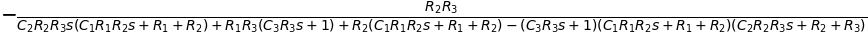

In [41]:
H = u[v5]/V1 # system function
H # display the system function

In [42]:
num, denom = fraction(H) #returns numerator and denominator

The following SymPy code collects and expands the system equation around s.

In [43]:
collect((denom/num).expand(),s)

The results above are the same as in [1].

The element values are entered into the equations so that a numerical solution can be obtained.

In [44]:
# find a numerical solution, substitute the element values
equ = equ.subs({R1:22.65e3,R2:22.65e3,R3:22.65e3,R4:1e3,C1:6940e-12,C2:0.01e-6,C3:1783e-12})
equ  # display the equations

⎡                       I_V1 + 4.41501103752759e-5⋅v₁ - 4.41501103752759e-5⋅v₂
⎢                                                                             
⎢      -4.41501103752759e-5⋅v₁ + v₂⋅(6.94e-9⋅s + 8.83002207505519e-5) - 4.4150
⎢                                                                             
⎢-1.0e-8⋅s⋅v₅ - 4.41501103752759e-5⋅v₂ + v₃⋅(1.0e-8⋅s + 8.83002207505519e-5) -
⎢                                                                             
⎢                  -4.41501103752759e-5⋅v₃ + v₄⋅(1.783e-9⋅s + 4.41501103752759
⎢                                                                             
⎢                             I_O - 1.0e-8⋅s⋅v₃ + v₅⋅(1.0e-8⋅s + 0.001) = 0   
⎢                                                                             
⎢                                                v₁ = V₁                      
⎢                                                                             
⎣                                              v₄ - 

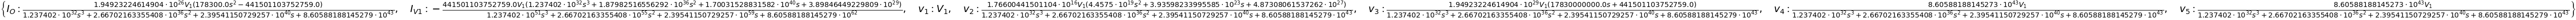

In [45]:
# solve for the unknowns
u1 = solve(equ,[v1, v2, v3, v4, v5, I_V1, I_O])
u1

Notice that the values of the exponents are very large in the solution. The numerator and denominator for v5 could be divided by 1e43. Another option for avoiding large exponents is to 1st normalize the component values by frequency scaling. I suppose that large exponents don't become a problem as long as they remain under two digits.

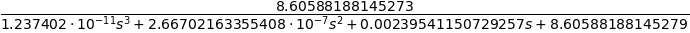

In [46]:
num, denom = fraction(u1[v5])
(num/1e43)/(denom/1e43)/V1

Almost all platforms map Python floats to the IEEE754 double precision - 64 total bits. The float information using the sys package can be as shown as follows:

In [47]:
import sys
sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

Letting SciPy do the math and not worrying about the size of the exponents. The system transfer function, is $H(s) = \frac {v5}{V1}$

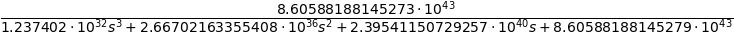

In [48]:
H = u1[v5]/V1
H

Extract the numerator and denominator polynomials so that the system can be defined in SciPy.

In [49]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system_c1 = (a, b) # system for circuit 1

### Plot the impulse and step response
Use the SciPy functions [impulse2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.impulse2.html) and [step2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.step2.html) to plot the impulse and step response of the system.

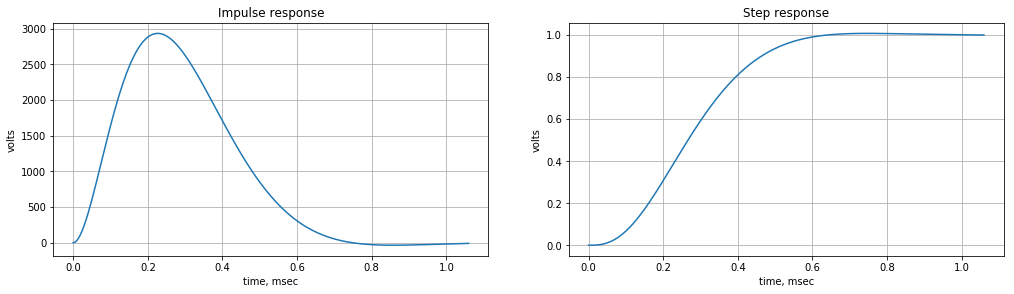

In [50]:
# figsize() function to adjust the size
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_c1,N=500)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_c1,N=500)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

The [impulse](https://en.wikipedia.org/wiki/Impulse_response) and [step response](https://en.wikipedia.org/wiki/Step_response) of the filter are plotted above. Any linear, time-invariant is completely characterized by its impulse response. The transfer function is the Laplace transform of the impulse response. The impulse response defines the response of a linear time-invariant system for all frequencies.

In practical systems, it is not possible to produce a perfect impulse to serve as input for testing; therefore, a brief pulse is sometimes used as an approximation of an impulse. Provided that the pulse is short enough compared to the impulse response, the result will be close to the true, theoretical, impulse response.

LTspice plot is shown below. The input pulse was set to an amplitude of 100 volts and a 0.1ms duration. The overall shape of the response agrees with python results except for the amplitude which LTspice has at a bit below 3.3 volts and SciPy has at almost 3000 volts. I'm not sure why there is a difference.

In electronic engineering and control theory, step response is the time behavior of the outputs of a general system when its inputs change from zero to one in a very short time.

From a practical standpoint, knowing how the system responds to a sudden input is important because large and possibly fast deviations from the long term steady state may have extreme effects on the component itself and on other portions of the overall system dependent on this component.

The LTspice plot of the step response is shown below and agrees with the SciPy results.

### Plot the Bode magnitude and phase data
Use the SciPy function [bode](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) to plot the magnitude and phase of the filter.

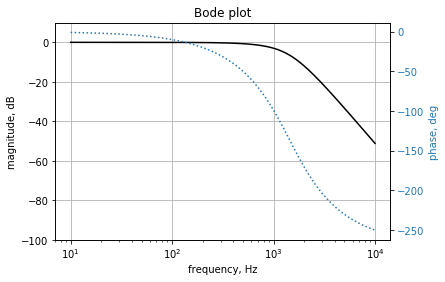

In [51]:
x = np.linspace(10*2*np.pi, 10e3*2*np.pi, 1000, endpoint=True)
w, mag, phase = signal.bode(system_c1, w=x)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

#plt.semilogx(w, mag)    # Bode magnitude plot
#plt.plot(w/(2*np.pi*1e6), mag,'-k')    # Bode magnitude plot
#plt.plot(w/(2*np.pi), mag,'-k')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
ax1.set_ylim((-100,10))
#ax1.set_xlim((27e6*2*np.pi,33e6*2*np.pi))
#ax1.set_xlim((27,33))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

#plt.semilogx(w, phase,'-g')  # Bode phase plot
#plt.plot(w/(2*np.pi), phase,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

The plot above agrees with the LTspice simulation of the circuit shown below.

In electrical engineering, a Bode plot is a graph of the frequency response of a system. It is usually a combination of the magnitude (usually in decibels) of the frequency response and the phase shift. As originally conceived by Hendrik Wade Bode in the 1930s, the plot is an asymptotic approximation of the frequency response, using straight line segments. Bode plots are used to assess the stability of systems by finding the gain and phase margins.

In [52]:
# Find neasest position in the array where the value is located
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

In [53]:
# gain margin
print('gain margin = {:.2f} dB'.format(mag[find_nearest(phase, -180)]))

gain margin = -13.94 dB


In [54]:
# phase margin
print('phase margin = {:.2f} deg'.format(phase[find_nearest(mag, -0.1 )] - (-180)))

phase margin = 160.96 deg


#### Plot the group delay.
The following python code calculates and plots [group delay](https://en.wikipedia.org/wiki/Group_delay_and_phase_delay#). Frequency components of a signal are delayed when passed through a circuit and the signal delay will be different for the various frequencies unless the circuit has the property of being linear phase. The delay variation means that signals consisting of multiple frequency components will suffer distortion because these components are not delayed by the same amount of time at the output of the device.

Group delay: $\tau _{g}(\omega )=-\frac  {d\phi (\omega )}{d\omega }$

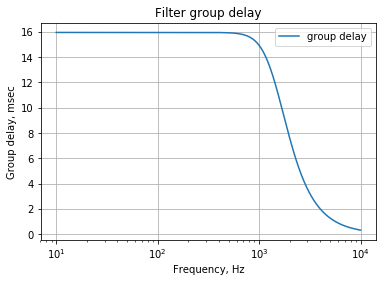

In [55]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
plt.legend()
plt.grid()
plt.show()

Group delay for the circuit plotted by LTspice.

The results obtained from the python code do not agree with LTspice. LTspice shows the group delay at 100Hz to be -278.4us, the plot above shows 16msec at about 100Hz. LTspice gives the phase at -10.5 deg at 100Hz, the bode plot above shows about -10 degrees. This difference needs to be explored.

## OpAmp circuit 2
The circuit shown below implements a High Pass Filter from the reference below, example 4-8, page 4-16. The high pass filter is implemented with a Generalized Impedance Converter (GIC). The filter is an active high pass filter with a 3 dB cutoff at 1200Hz. The The inductor is replaced by a GIC in the prototype and the values are impedance and frequency scaled. The GIC is an active two port network in which the input impedance is equal to the load impedance times a conversion function of the complex frequency variable.

The netlist was generated by LTspice is and edited to be compatible with the MNA code.
```
V1 1 0 AC 1
C1 2 3 6000p
C2 7 8 0.0133µ
C3 3 4 6000p
R1 1 2 10k
R2 5 3 10k
R3 5 6 10k
R4 6 7 10k
R5 8 0 9090
XU1 3 6 VCC VEE 7 LT1007
XU2 8 6 VCC VEE 5 LT1007
Vneg1 0 VEE 15
Vpos1 VCC 0 15
R6 4 0 10k
;op
.ac dec 100 10 10000
;tran 20m
.lib LTC.lib
```

The following equations were generated by the MNA code.
~~~
[[Eq(I_V1 + v1/R1 - v2/R1, 0)],
[Eq(-C1*s*v3 + v2*(C1*s + 1/R1) - v1/R1, 0)],
[Eq(-C1*s*v2 - C3*s*v4 + v3*(C1*s + C3*s + 1/R2) - v5/R2, 0)],
[Eq(-C3*s*v3 + v4*(C3*s + 1/R6), 0)],
[Eq(I_O2 + v5*(1/R3 + 1/R2) - v6/R3 - v3/R2, 0)],
[Eq(v6*(1/R4 + 1/R3) - v7/R4 - v5/R3, 0)],
[Eq(-C2*s*v8 + I_O1 + v7*(C2*s + 1/R4) - v6/R4, 0)],
[Eq(-C2*s*v7 + v8*(C2*s + 1/R5), 0)],
[Eq(v1, V1)], [Eq(v3 - v6, 0)], [Eq(-v6 + v8, 0)]]
~~~

Reference:  
Electronic Filter Design Handbook, Arther B. Williams, McGraw-Hill 1981

In [56]:
# declare the following symbols
v1, R3, v6, v7, C1, v3, v8, V1, R5, I_O2, C2, I_O1, v4, R6, R1, I_V1, s, v2, v5, R2, C3, R4 = symbols('v1 R3 v6 v7 C1 v3 v8 V1 R5 I_O2 C2 I_O1 v4 R6 R1 I_V1 s v2 v5 R2 C3 R4')

# use the equations generated by nodal analysis
equ = Matrix(
    [[Eq(I_V1 + v1/R1 - v2/R1, 0)],
    [Eq(-C1*s*v3 + v2*(C1*s + 1/R1) - v1/R1, 0)],
    [Eq(-C1*s*v2 - C3*s*v4 + v3*(C1*s + C3*s + 1/R2) - v5/R2, 0)],
    [Eq(-C3*s*v3 + v4*(C3*s + 1/R6), 0)],
    [Eq(I_O2 + v5*(1/R3 + 1/R2) - v6/R3 - v3/R2, 0)],
    [Eq(v6*(1/R4 + 1/R3) - v7/R4 - v5/R3, 0)],
    [Eq(-C2*s*v8 + I_O1 + v7*(C2*s + 1/R4) - v6/R4, 0)],
    [Eq(-C2*s*v7 + v8*(C2*s + 1/R5), 0)],
    [Eq(v1, V1)], [Eq(v3 - v6, 0)], [Eq(-v6 + v8, 0)]])
equ

⎡                       v₁   v₂                     ⎤
⎢                I_V1 + ── - ── = 0                 ⎥
⎢                       R₁   R₁                     ⎥
⎢                                                   ⎥
⎢                      ⎛       1 ⎞   v₁             ⎥
⎢        -C₁⋅s⋅v₃ + v₂⋅⎜C₁⋅s + ──⎟ - ── = 0         ⎥
⎢                      ⎝       R₁⎠   R₁             ⎥
⎢                                                   ⎥
⎢                        ⎛              1 ⎞   v₅    ⎥
⎢-C₁⋅s⋅v₂ - C₃⋅s⋅v₄ + v₃⋅⎜C₁⋅s + C₃⋅s + ──⎟ - ── = 0⎥
⎢                        ⎝              R₂⎠   R₂    ⎥
⎢                                                   ⎥
⎢                         ⎛       1 ⎞               ⎥
⎢           -C₃⋅s⋅v₃ + v₄⋅⎜C₃⋅s + ──⎟ = 0           ⎥
⎢                         ⎝       R₆⎠               ⎥
⎢                                                   ⎥
⎢                   ⎛1    1 ⎞   v₆   v₃             ⎥
⎢         I_O2 + v₅⋅⎜── + ──⎟ - ── - ── = 0         ⎥
⎢                   ⎝R₃   R₂

Find the symbolic solution.

In [57]:
# this works but takes awhile and makes scrolling slow
# find symbolic solution
u = solve(equ,[v1, v2, v3, v4, v5, v6, v7, v8, I_V1, I_O1, I_O2])
#u # display the solution

Find the symbolic transfer function.

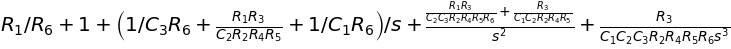

In [58]:
H = u[v4]/V1
num, denom = fraction(H) #returns numerator and denominator
collect((denom/num).expand(),s)

The element values are entered into the equations so that a numerical solution can be obtained.

In [59]:
# find a numerical solution, substitute the element values
equ = equ.subs({C1:6000e-12,C2:0.0133e-6,C3:6000e-12,R1:10e3,R2:10e3,R3:10e3,R4:10e3,R5:9090,R6:10e3})
equ  # display the equations

⎡                 I_V1 + 0.0001⋅v₁ - 0.0001⋅v₂ = 0                  ⎤
⎢                                                                   ⎥
⎢       -6.0e-9⋅s⋅v₃ - 0.0001⋅v₁ + v₂⋅(6.0e-9⋅s + 0.0001) = 0       ⎥
⎢                                                                   ⎥
⎢-6.0e-9⋅s⋅v₂ - 6.0e-9⋅s⋅v₄ + v₃⋅(1.2e-8⋅s + 0.0001) - 0.0001⋅v₅ = 0⎥
⎢                                                                   ⎥
⎢             -6.0e-9⋅s⋅v₃ + v₄⋅(6.0e-9⋅s + 0.0001) = 0             ⎥
⎢                                                                   ⎥
⎢           I_O2 - 0.0001⋅v₃ + 0.0002⋅v₅ - 0.0001⋅v₆ = 0            ⎥
⎢                                                                   ⎥
⎢              -0.0001⋅v₅ + 0.0002⋅v₆ - 0.0001⋅v₇ = 0               ⎥
⎢                                                                   ⎥
⎢   I_O1 - 1.33e-8⋅s⋅v₈ - 0.0001⋅v₆ + v₇⋅(1.33e-8⋅s + 0.0001) = 0   ⎥
⎢                                                                   ⎥
⎢            -1.33e-

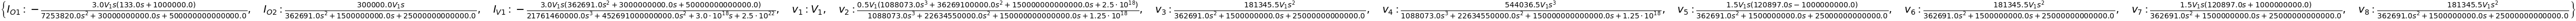

In [60]:
# solve for the unknowns
u1 = solve(equ,[v1, v2, v3, v4, v5, v6, v7, v8, I_V1, I_O1, I_O2])
u1

The system transfer function, is $H(s) = V4/V1$

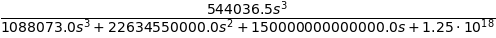

In [61]:
H = u1[v4]/V1
H

In [62]:
# Extract the numerator and denominator polynomials so that the system can be defined in scipy.
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system_c2 = (a, b) # system for circuit 2

### Plot the impulse and step response

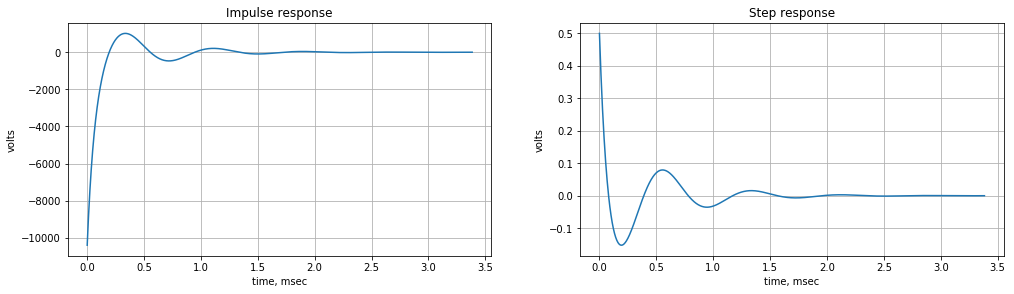

In [63]:
# figsize() function to adjust the size
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_c2,N=5000)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_c2,N=1000)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

### Plot the Bode magnitude and phase

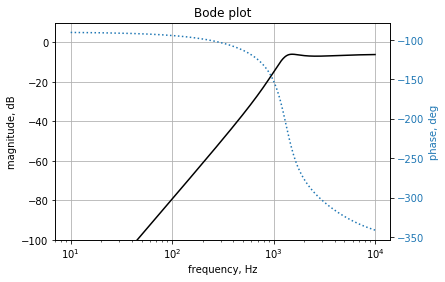

In [64]:
x = np.linspace(10*2*np.pi, 10e3*2*np.pi, 1000, endpoint=True)
w, mag, phase = signal.bode(system_c2, w=x)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

#plt.semilogx(w, mag)    # Bode magnitude plot
#plt.plot(w/(2*np.pi*1e6), mag,'-k')    # Bode magnitude plot
#plt.plot(w/(2*np.pi), mag,'-k')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
ax1.set_ylim((-100,10))
#ax1.set_xlim((27e6*2*np.pi,33e6*2*np.pi))
#ax1.set_xlim((27,33))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

#plt.semilogx(w, phase,'-g')  # Bode phase plot
#plt.plot(w/(2*np.pi), phase,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

### Plot the group delay

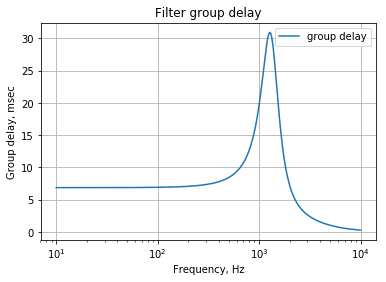

In [65]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
plt.legend()
plt.grid()
plt.show()

## OpAmp circuit 3
The circuit shown below implements a 2nd order 1 dB Chebyshev active low pass filter with a 3 dB cutoff at 1000Hz. The design presented here follows example 3-11 of [1], page 3.25, VCVS uniform capacitor structure, 1st section only, with some changes. This structure features equal capacitors. The value of C is chosen to be 0.01uF. The pole locations are from table 11-26 , alpha = 0.4508 and beta = 0.7351.  

Reference:  
1. Electronic Filter Design Handbook, Arther B. Williams, McGraw-Hill 3rd edition, 1995

In [66]:
# Design equations 
FSF = 2*np.pi*1000 # frequency scaling factor
alpha = 0.4508
beta = 0.7351
C = 0.01e-6

alpha_p = alpha*FSF
beta_p = beta*FSF
R1 = 1/(2*alpha_p*C)
R2 = 2*alpha_p/(C*(alpha_p**2+beta_p**2))

print('R1={:.2f}k ohms, R2={:.2f}k ohms'.format(R1/1000,R2/1000))

R1=17.65k ohms, R2=19.30k ohms


The schematic was entered into LTspice and the netlist was generated.
```
* OpAmp circuit 3.asc
V1 1 0 1
O1 3 4 5
C1 2 5 0.01µ
C2 3 0 0.01µ
R1 1 2 17.65k
R2 2 3 19.3k
R3 0 4 10k
R4 4 5 10k
```

The MNA code produced the following equations:
```
[[Eq(I_V1 + v1/R1 - v2/R1, 0)],
[Eq(-C1*s*v5 + v2*(C1*s + 1/R2 + 1/R1) - v3/R2 - v1/R1, 0)],
[Eq(v3*(C2*s + 1/R2) - v2/R2, 0)],
[Eq(v4*(1/R4 + 1/R3) - v5/R4, 0)],
[Eq(-C1*s*v2 + I_O1 + v5*(C1*s + 1/R4) - v4/R4, 0)],
[Eq(v1, V1)], [Eq(v3 - v4, 0)]]
```

In [67]:
# declare the following symbols
v1, R3, C1, v3, V1, C2, I_O1, v4, R1, I_V1, s, v2, v5, R2, R4 = symbols('v1 R3 C1 v3 V1 C2 I_O1 v4 R1 I_V1 s v2 v5 R2 R4')

# use the equations generated by nodal analysis
equ = Matrix(
    [[Eq(I_V1 + v1/R1 - v2/R1, 0)],
    [Eq(-C1*s*v5 + v2*(C1*s + 1/R2 + 1/R1) - v3/R2 - v1/R1, 0)],
    [Eq(v3*(C2*s + 1/R2) - v2/R2, 0)],
    [Eq(v4*(1/R4 + 1/R3) - v5/R4, 0)],
    [Eq(-C1*s*v2 + I_O1 + v5*(C1*s + 1/R4) - v4/R4, 0)],
    [Eq(v1, V1)], [Eq(v3 - v4, 0)]])
equ

⎡                    v₁   v₂                 ⎤
⎢             I_V1 + ── - ── = 0             ⎥
⎢                    R₁   R₁                 ⎥
⎢                                            ⎥
⎢              ⎛       1    1 ⎞   v₃   v₁    ⎥
⎢-C₁⋅s⋅v₅ + v₂⋅⎜C₁⋅s + ── + ──⎟ - ── - ── = 0⎥
⎢              ⎝       R₂   R₁⎠   R₂   R₁    ⎥
⎢                                            ⎥
⎢             ⎛       1 ⎞   v₂               ⎥
⎢          v₃⋅⎜C₂⋅s + ──⎟ - ── = 0           ⎥
⎢             ⎝       R₂⎠   R₂               ⎥
⎢                                            ⎥
⎢              ⎛1    1 ⎞   v₅                ⎥
⎢           v₄⋅⎜── + ──⎟ - ── = 0            ⎥
⎢              ⎝R₄   R₃⎠   R₄                ⎥
⎢                                            ⎥
⎢                      ⎛       1 ⎞   v₄      ⎥
⎢ -C₁⋅s⋅v₂ + I_O1 + v₅⋅⎜C₁⋅s + ──⎟ - ── = 0  ⎥
⎢                      ⎝       R₄⎠   R₄      ⎥
⎢                                            ⎥
⎢                  v₁ = V₁                   ⎥
⎢            

The element values are entered into the equations so that a numerical solution can be obtained.

In [68]:
# find a numerical solution, substitute the element values
equ = equ.subs({C1:0.01e-6,C2:0.01e-6,R1:17.65e3,R2:19.3e3,R3:10e3,R4:10e3})
equ  # display the equations

⎡                        I_V1 + 5.6657223796034e-5⋅v₁ - 5.6657223796034e-5⋅v₂ 
⎢                                                                             
⎢-1.0e-8⋅s⋅v₅ - 5.6657223796034e-5⋅v₁ + v₂⋅(1.0e-8⋅s + 0.000108470695298625) -
⎢                                                                             
⎢                   -5.18134715025907e-5⋅v₂ + v₃⋅(1.0e-8⋅s + 5.18134715025907e
⎢                                                                             
⎢                                       0.0002⋅v₄ - 0.0001⋅v₅ = 0             
⎢                                                                             
⎢                      I_O1 - 1.0e-8⋅s⋅v₂ - 0.0001⋅v₄ + v₅⋅(1.0e-8⋅s + 0.0001)
⎢                                                                             
⎢                                                v₁ = V₁                      
⎢                                                                             
⎣                                              v₃ - 

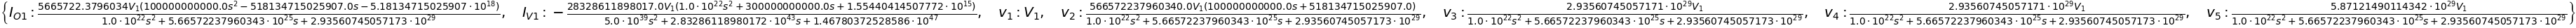

In [69]:
# solve for the unknowns
u1 = solve(equ,[v1, v2, v3, v4, v5, I_V1, I_O1])
u1

The system transfer function, is $H(s) = V4/V1$

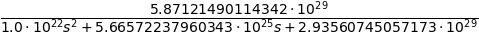

In [70]:
H = u1[v5]/V1
H

Extract the numerator and denominator polynomials so that the system can be defined in scipy.

In [71]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system_c3 = (a, b) # system for circuit 3

### Plot the impulse and step response

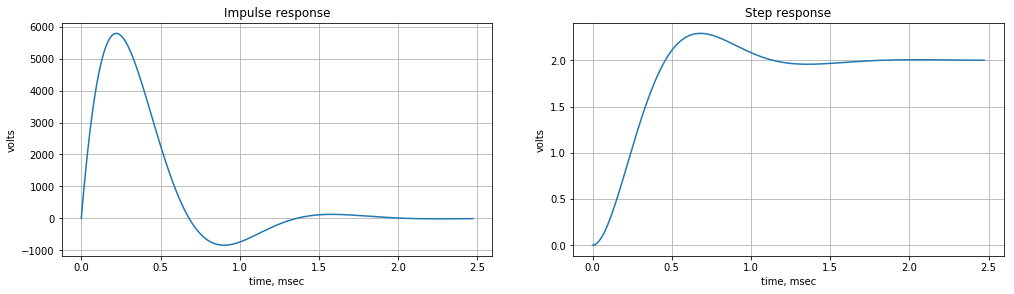

In [72]:
# figsize() function to adjust the size
plt.subplots(figsize=(15, 5))

# using subplot function and creating
# plot one
plt.subplot(1, 2, 1)

# impulse response
t, y = signal.impulse2(system_c3,N=5000)
plt.plot(t/1e-3, y)
plt.title('Impulse response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# using subplot function and creating plot two
plt.subplot(1, 2, 2)

t, y = signal.step2(system_c3,N=1000)
plt.plot(t/1e-3, y)
plt.title('Step response')
plt.ylabel('volts')
plt.xlabel('time, msec')
plt.grid()

# space between the plots
plt.tight_layout(4)

# show plot
plt.show()

### Plot the Bode magnitude and phase

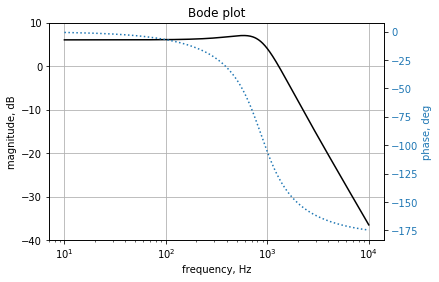

In [73]:
x = np.linspace(10*2*np.pi, 10e3*2*np.pi, 1000, endpoint=True)
w, mag, phase = signal.bode(system_c3, w=x)

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

#plt.semilogx(w, mag)    # Bode magnitude plot
#plt.plot(w/(2*np.pi*1e6), mag,'-k')    # Bode magnitude plot
#plt.plot(w/(2*np.pi), mag,'-k')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
ax1.set_ylim((-40,10))
#ax1.set_xlim((27e6*2*np.pi,33e6*2*np.pi))
#ax1.set_xlim((27,33))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

#plt.semilogx(w, phase,'-g')  # Bode phase plot
#plt.plot(w/(2*np.pi), phase,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

### Plot the group delay

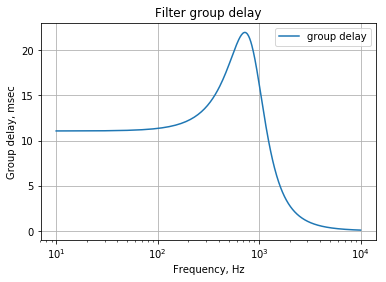

In [74]:
plt.title('Filter group delay')
plt.semilogx(w/(2*np.pi), -np.gradient(phase)/np.gradient(w)/1e-3,'-',label='group delay')
#plt.semilogx(w/(2*np.pi), -np.gradient(phase)/w/1e-3,'-',label='phase delay')
plt.ylabel('Group delay, msec')
plt.xlabel('Frequency, Hz')
plt.legend()
plt.grid()
plt.show()